very loosely based on https://keras.io/examples/vision/mnist_convnet/

In [ ]:
outdim=2

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
bx_train = np.expand_dims(x_train, -1)
bx_test = np.expand_dims(x_test, -1)
print("x_train shape:", bx_train.shape)
print(bx_train.shape[0], "train samples")
print(bx_test.shape[0], "test samples")


# convert class vectors to binary class matrices
by_train = keras.utils.to_categorical(y_train, num_classes)
by_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
classes=[0,1]
x_train=np.array(
    [xx for xx,yy in zip(bx_train,by_train) if
      np.any([yy[cc] for cc in classes])
    ])
y_train=np.array([yy for yy in by_train if np.any([yy[cc] for cc in classes])])
print(x_train.shape)
print(y_train.shape)

xa_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      not np.any([yy[cc] for cc in classes])
    ])
ya_test=np.array([yy for yy in by_test if not np.any([yy[cc] for cc in classes])])
print(xa_test.shape)
print(ya_test.shape)
xn_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      np.any([yy[cc] for cc in classes])
    ])
yn_test=np.array([yy for yy in by_test if np.any([yy[cc] for cc in classes])])
print(xn_test.shape)
print(yn_test.shape)



(12665, 28, 28, 1)
(12665, 10)
(7885, 28, 28, 1)
(7885, 10)
(2115, 28, 28, 1)
(2115, 10)


In [ ]:
def loss(outdim):
    if outdim==1:
        def lss(a,b):
            q=b
            return K.mean((q-1)**2)
        return lss
    def lss(a,b):
        q=b
        pd=[i for i in range(len(q.shape))]
        pd.remove(pd[-1])
        pd.insert(0,len(pd))
        #print(pd)
        q=K.permute_dimensions(q,tuple(pd))
        #exit()

        #print(q.shape)

        adl=None

        for i in range(outdim):
            for j in range(i+1,outdim):
              ac=K.abs(K.mean(((q[i]-1)*(q[j]-1))))
              if adl is None:
                  adl=ac
              else:
                  adl+=ac

        return adl
    return lss

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(7, 7), activation="relu",use_bias=False),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(4, 4), activation="relu",use_bias=False),
        layers.Conv2D(16, kernel_size=(4, 4), activation="relu",use_bias=False),
        layers.Conv2D(4, kernel_size=(2, 2), activation="relu",use_bias=False),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(4,kernel_size=(1,1),activation="linear",padding="same",use_bias=False),
        layers.Flatten(),
        layers.Dense(outdim,use_bias=False)
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          32768     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 16)          16384     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 4)           256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 4)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 4)           1

In [ ]:
batch_size = 128
epochs = 5

model.compile(loss=loss(outdim), optimizer="adam", metrics=[])

model.fit(x_train,
          np.ones_like(x_train),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Epoch 1/5
90/90 [==============================] - 12s 120ms/step - loss: 0.0818 - val_loss: 0.0048
Epoch 2/5
90/90 [==============================] - 11s 118ms/step - loss: 0.0072 - val_loss: 0.0033
Epoch 3/5
90/90 [==============================] - 11s 118ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 4/5
90/90 [==============================] - 11s 117ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 5/5
90/90 [==============================] - 11s 117ms/step - loss: 0.0019 - val_loss: 0.0015


In [ ]:
pa=model.predict(xa_test)
pn=model.predict(xn_test)

In [ ]:
print(pa.shape)
print(pn.shape)

(7885, 2)
(2115, 2)


In [ ]:
da=np.abs(pa-1)
dn=np.abs(pn-1)
dfa=np.sqrt(np.mean(da**2,axis=1))
dfn=np.sqrt(np.mean(dn**2,axis=1))
print(dfa.shape,dfn.shape)

(7885,) (2115,)


In [ ]:
print("normal",np.mean(dfn),np.std(dfn))
print("abnorm",np.mean(dfa),np.std(dfa))

normal 0.10881145 0.054628227
abnorm 0.12916256 0.06580681


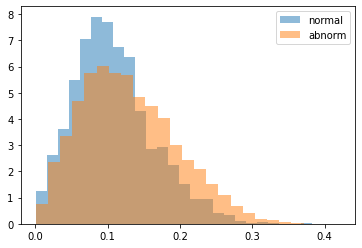

In [ ]:
import matplotlib.pyplot as plt

plt.hist(dfn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(dfa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

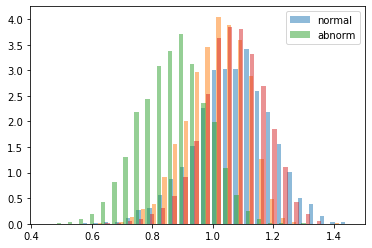

In [ ]:
plt.hist(pn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(pa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

In [ ]:
def dexbyloss(lss):return np.argmin(np.mean((pn-lss)**2,axis=1))
minl=np.min(pn,axis=0)
maxl=np.max(pn,axis=0)
print(minl,maxl)
ls=[np.arange(aminl,amaxl,(amaxl-aminl)/9.0001) for aminl,amaxl in zip(minl,maxl)]
print(minl,ls,maxl)
print(len(ls))

[0.5658122  0.62426955] [1.4567937 1.4071004]
[0.5658122  0.62426955] [array([0.56581217, 0.66480901, 0.76380586, 0.8628027 , 0.96179955,
       1.06079639, 1.15979323, 1.25879008, 1.35778692, 1.45678377]), array([0.62426955, 0.71124979, 0.79823003, 0.88521028, 0.97219052,
       1.05917077, 1.14615101, 1.23313125, 1.3201115 , 1.40709174])] [1.4567937 1.4071004]
2


In [ ]:
dex=[[dexbyloss([l0,l1]) for l1 in ls[1]] for l0 in ls[0]]
print(dex)

[[1370, 1370, 1370, 111, 1398, 1398, 1397, 1397, 392, 1664], [1370, 792, 792, 111, 1558, 1397, 392, 392, 1664, 1664], [461, 461, 696, 2066, 80, 1886, 392, 1664, 1664, 1664], [744, 391, 66, 570, 1508, 1742, 2042, 734, 1633, 1633], [86, 627, 1822, 483, 1078, 1216, 661, 1655, 1633, 1906], [86, 536, 659, 945, 1346, 1665, 2022, 901, 1906, 1906], [956, 956, 287, 433, 1231, 186, 868, 768, 69, 1906], [848, 607, 1157, 30, 1202, 1825, 1452, 1818, 5, 1906], [4, 4, 98, 1591, 1318, 249, 1925, 1925, 5, 5], [4, 1111, 1111, 1611, 1310, 1310, 1925, 1925, 1925, 5]]


In [ ]:
topl=np.array([[xn_test[d] for d in dd] for dd in dex])
print(topl.shape)


(10, 10, 28, 28, 1)


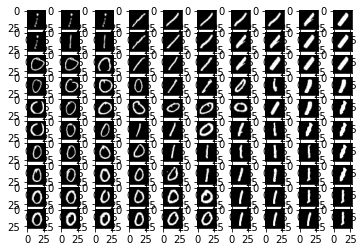

In [ ]:
for i,zx in enumerate(topl):
  for j,zw in enumerate(zx):

    plt.subplot(len(topl),len(zx),1+len(zx)*i+j)
    plt.imshow(zw[:,:,0], cmap=plt.get_cmap('gray'))
plt.show()

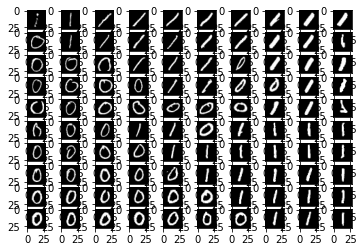

In [ ]:

addon=np.zeros(len(pn),dtype="float")
def dexbyloss(lss):
  dex= np.argmin(np.mean((pn-lss)**2,axis=1)+addon)
  addon[dex]=1000.0
  return dex

ls=[np.arange(aminl,amaxl,(amaxl-aminl)/9.0001) for aminl,amaxl in zip(minl,maxl)]
dex=[[dexbyloss([l0,l1]) for l1 in ls[1]] for l0 in ls[0]]

topl=np.array([[xn_test[d] for d in dd] for dd in dex])

for i,zx in enumerate(topl):
  for j,zw in enumerate(zx):

    plt.subplot(len(topl),len(zx),1+len(zx)*i+j)
    plt.imshow(zw[:,:,0], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
td=np.array([[np.argmax(yn_test[d]) for d in dd] for dd in dex])
print(td)

[[1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 0 1 1 1]
 [0 0 0 0 1 1 0 0 1 1]
 [0 0 0 0 0 0 0 1 1 1]
 [0 0 0 1 1 0 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1]]


In [ ]:
print(np.mean(td,axis=0),np.mean(np.std(td,axis=0)))
print(np.mean(td,axis=1),np.mean(np.std(td,axis=1)))

[0.1 0.2 0.2 0.4 0.6 0.6 0.6 0.9 1.  1. ] 0.3359591794226543
[1.  0.9 0.6 0.4 0.3 0.6 0.6 0.5 0.4 0.3] 0.4166004881774346


In [ ]:
p=model.predict(x_train)


In [ ]:
mp=np.mean(p,axis=0)
da=np.abs(pa-mp)
dn=np.abs(pn-mp)
dfa=np.sqrt(np.mean(da**2,axis=1))
dfn=np.sqrt(np.mean(dn**2,axis=1))
print(dfa.shape,dfn.shape)

(7885,) (2115,)


In [ ]:
print("normal",np.mean(dfn),np.std(dfn))
print("abnorm",np.mean(dfa),np.std(dfa))

normal 0.098090105 0.0524144
abnorm 0.16017343 0.07203087


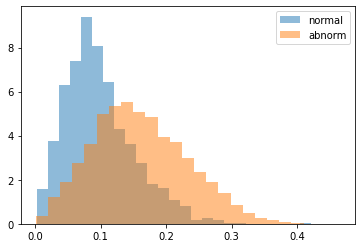

In [ ]:
plt.hist(dfn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(dfa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

In [ ]:
y_score=np.concatenate((dfn,dfa),axis=0)
y_true=np.concatenate((np.zeros_like(dfn),np.ones_like(dfa)),axis=0)

print(y_true.shape,y_score.shape)

(10000,) (10000,)


In [ ]:
from sklearn.metrics import roc_auc_score as rauc

auc=rauc(y_true,y_score)
print(auc)

0.7580328031049168
